In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from typing import List, Dict, Tuple
import matplotlib.pyplot as plt
from transformers import RobertaTokenizer, RobertaForSequenceClassification

In [2]:
class TestDataset(Dataset):
    def __init__(self, texts: List[str], labels: List[int], tokenizer, max_length: int = 512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            truncation=True,
            padding='max_length',
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [3]:
def plot_confusion_matrix(cm, labels):
    """Plot confusion matrix using seaborn"""
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [4]:
def evaluate_model_comprehensive(model, dataset: TestDataset, device: str):
    """Comprehensive model evaluation with detailed metrics"""
    model.eval()
    dataloader = DataLoader(dataset, batch_size=32)
    
    all_predictions = []
    all_labels = []
    all_probs = []
    
    print("Starting evaluation...")
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=1)
            predictions = torch.argmax(logits, dim=1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Convert to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    
    # Calculate metrics
    cm = confusion_matrix(all_labels, all_predictions)
    
    # Print detailed results
    print("\nConfusion Matrix:")
    print(cm)
    
    print("\nClassification Report:")
    print(classification_report(all_labels, all_predictions, 
                              target_names=['Negative', 'Positive'],
                              digits=4))
    
    # Calculate additional metrics
    tn, fp, fn, tp = cm.ravel()
    
    specificity = tn / (tn + fp)
    npv = tn / (tn + fn)  # Negative Predictive Value
    
    print("\nAdditional Metrics:")
    print(f"Specificity (True Negative Rate): {specificity:.4f}")
    print(f"Negative Predictive Value: {npv:.4f}")
    
    # Plot confusion matrix
    plot_confusion_matrix(cm, ['Negative', 'Positive'])
    
    return cm, all_predictions, all_probs, all_labels

In [5]:
def main():
    # Set device
    device = torch.cuda.is_available() and 'cuda' or 'cpu'
    print(f"Using device: {device}")
    
    # Load test dataset
    test_df = pd.read_csv('datasets/imdb_dataset_test.csv')
    
    # Convert labels to integers
    label_map = {'negative': 0, 'positive': 1}
    labels = [label_map[label] for label in test_df['sentiment']]
    
    # Initialize model and tokenizer
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    model = RobertaForSequenceClassification.from_pretrained('roberta-base')
    
    # Load your fine-tuned model weights - now matches your save format
    checkpoint = torch.load('model_checkpoints/model_iteration_3.pt')  # adjust path as needed
    model.load_state_dict(checkpoint)
    model.to(device)
    
    # Create test dataset
    test_dataset = TestDataset(
        texts=test_df['review'].tolist(),
        labels=labels,
        tokenizer=tokenizer
    )
    
    # Run evaluation
    cm, predictions, probabilities, true_labels = evaluate_model_comprehensive(
        model, test_dataset, device
    )
    
    # Additional analysis: Look at most confident predictions
    prediction_confidences = np.max(probabilities, axis=1)
    
    # Get indices of most confident predictions
    most_confident_idx = np.argsort(prediction_confidences)[-5:]  # Top 5 most confident
    least_confident_idx = np.argsort(prediction_confidences)[:5]  # Top 5 least confident
    
    print("\nMost Confident Predictions:")
    for idx in most_confident_idx:
        print(f"\nReview snippet: {test_df['review'].iloc[idx][:100]}...")
        print(f"True label: {test_df['sentiment'].iloc[idx]}")
        print(f"Predicted: {'positive' if predictions[idx] == 1 else 'negative'}")
        print(f"Confidence: {prediction_confidences[idx]:.4f}")
    
    print("\nLeast Confident Predictions:")
    for idx in least_confident_idx:
        print(f"\nReview snippet: {test_df['review'].iloc[idx][:100]}...")
        print(f"True label: {test_df['sentiment'].iloc[idx]}")
        print(f"Predicted: {'positive' if predictions[idx] == 1 else 'negative'}")
        print(f"Confidence: {prediction_confidences[idx]:.4f}")

Using device: cuda


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Carmine\AppData\Local\Temp\ipykernel_14860\901235911.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode 

Starting evaluation...

Confusion Matrix:
[[   0 5000]
 [   0 5000]]

Classification Report:
              precision    recall  f1-score   support

    Negative     0.0000    0.0000    0.0000      5000
    Positive     0.5000    1.0000    0.6667      5000

    accuracy                         0.5000     10000
   macro avg     0.2500    0.5000    0.3333     10000
weighted avg     0.2500    0.5000    0.3333     10000


Additional Metrics:
Specificity (True Negative Rate): 0.0000
Negative Predictive Value: nan


C:\Users\Carmine\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Carmine\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Carmine\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Carmine\AppData\Local\Tem

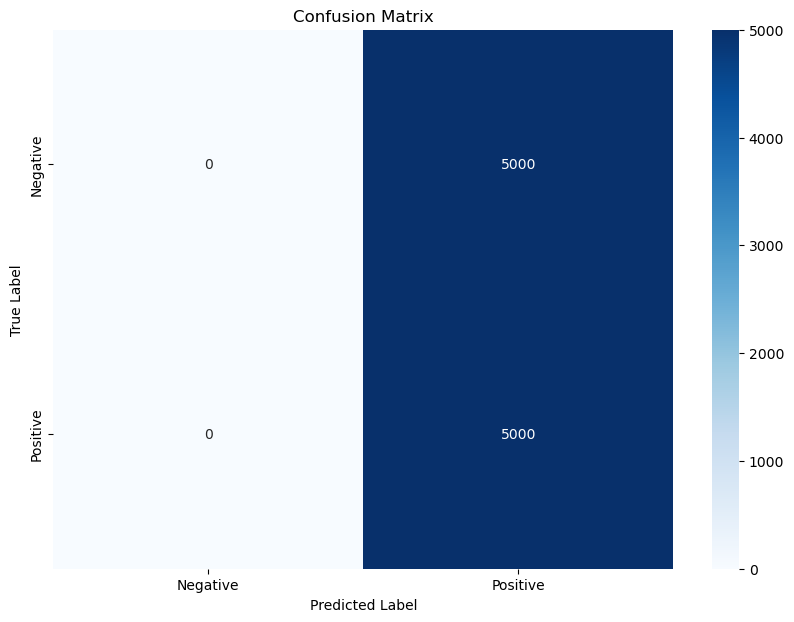


Most Confident Predictions:

Review snippet: Sorry to repeat myself over and over, but here's another great Columbo episode. I guess that's why I...
True label: positive
Predicted: positive
Confidence: 0.5255

Review snippet: I think that anybody whose dumb enough to risk being a wax dummy just so they can go to a football g...
True label: positive
Predicted: positive
Confidence: 0.5255

Review snippet: As an ordinary movie-watcher I can't say I enjoyed watching this one. It's not too emotional for a d...
True label: negative
Predicted: positive
Confidence: 0.5255

Review snippet: Mmmm, a previous summary says "if you like aliens and predator you will enjoy this film" i could not...
True label: negative
Predicted: positive
Confidence: 0.5255

Review snippet: This was the worst movie I have ever seen and I've seen a lot of bad movies. First of I'm from Kansa...
True label: negative
Predicted: positive
Confidence: 0.5255

Least Confident Predictions:

Review snippet: I wonder what audie

In [6]:
main()